<a href="https://colab.research.google.com/github/Muhammed-esmail/My-AI-Data-Engineering-Journey/blob/main/Cafe_Data_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Adding new data + Data Cleaning


In [4]:
import pandas as pd

In [6]:
from google.colab import auth

# Authenticate in Colab
auth.authenticate_user()

In [7]:
import duckdb
def clean(data):

  # Remove duplicates
  data.drop_duplicates(inplace=True)

  # Apply SQL cleaning script
  duckdb.sql("CREATE OR REPLACE TEMP TABLE cafe_sales AS SELECT * FROM data")
  cleaned = duckdb.sql("""
    WITH Removed_errors AS(
      SELECT
          REPLACE("Transaction ID", 'TXN_', '') AS "Transaction ID",
          CASE
              WHEN Item = 'ERROR' THEN NULL
              WHEN Item = 'UNKNOWN' THEN NULL
              WHEN Item = '' THEN NULL
              ELSE Item
          END AS Item,
          CASE
              WHEN Quantity = 'ERROR' THEN NULL
              WHEN Quantity = 'UNKNOWN' THEN NULL
              WHEN Quantity = '' THEN NULL
              ELSE Quantity
          END AS Quantity,
          CASE
              WHEN "Price Per Unit" = 'ERROR' THEN NULL
              WHEN "Price Per Unit" = 'UNKNOWN' THEN NULL
              WHEN "Price Per Unit" = '' THEN NULL
              ELSE "Price Per Unit"
          END AS "Price Per Unit",
          CASE
              WHEN "Total Spent" = 'ERROR' THEN NULL
              WHEN "Total Spent" = 'UNKNOWN' THEN NULL
              WHEN "Total Spent" = '' THEN NULL
              ELSE "Total Spent"
          END AS "Total Spent",
          CASE
              WHEN "Payment Method" = 'ERROR' THEN NULL
              WHEN "Payment Method" = 'UNKNOWN' THEN NULL
              WHEN "Payment Method" = '' THEN NULL
              ELSE "Payment Method"
          END AS "Payment Method",
          CASE
              WHEN Location = 'ERROR' THEN NULL
              WHEN Location = 'UNKNOWN' THEN NULL
              WHEN Location = '' THEN NULL
              ELSE Location
          END AS Location,
          CASE
              WHEN "Transaction Date" = 'ERROR' THEN NULL
              WHEN "Transaction Date" = 'UNKNOWN' THEN NULL
              WHEN "Transaction Date" = '' THEN NULL
              ELSE "Transaction Date"
          END AS "Transaction Date"
          FROM cafe_sales
    )
    SELECT
      CAST("Transaction ID" AS INTEGER) AS "Transaction ID",
      Item,
      CAST(Quantity AS INTEGER) AS Quantity,
      CAST("Price Per Unit" AS DOUBLE) AS "Price Per Unit",
      CAST("Total Spent" AS DOUBLE) AS "Total Spent",
      "Payment Method",
      Location,
      DATE("Transaction Date") AS "Transaction Date"
    FROM Removed_errors
    """).df()
  return cleaned

In [8]:
# Import data
data = pd.read_csv('dirty_cafe_sales.csv')

In [9]:
# Clean data
data = clean(data)

In [10]:
# View it
data.head(10)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,4271903,Cookie,4,1.0,NaN,Credit Card,In-store,2023-07-19
3,7034554,Salad,2,5.0,10.0,None,None,2023-04-27
4,3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
5,2602893,Smoothie,5,4.0,20.0,Credit Card,None,2023-03-31
6,4433211,None,3,3.0,9.0,None,Takeaway,2023-10-06
7,6699534,Sandwich,4,4.0,16.0,Cash,None,2023-10-28
8,4717867,None,5,3.0,15.0,None,Takeaway,2023-07-28
9,2064365,Sandwich,5,4.0,20.0,None,In-store,2023-12-31


In [15]:
# Save the new data into the database file

data.to_csv("big_data.csv", mode='a', header=False, index=False)

### Data Analysis on the Big Data set

In [16]:
df = pd.read_csv('big_data.csv')

In [17]:
# Earliest and Latest date in the table
date_range = (df['Transaction Date'].dropna().min(), df['Transaction Date'].dropna().max())
date_range

('2023-01-01', '2023-12-31')

In [18]:
# How many transactions occur per day
# Top 5 days
daily_top_5 = df['Transaction Date'].dropna().value_counts().reset_index().rename(columns={'index':'Date', 'Transaction Date':'Transactions'}).sort_values(by='count',ascending=False).head(5)
daily_top_5

,Transactions,count
0,2023-06-16,40
1,2023-02-06,40
5,2023-07-21,39
4,2023-07-24,39
3,2023-03-13,39


In [19]:
print("On Average:", int(df['Transaction Date'].dropna().value_counts().mean()), "transactions per day")


On Average: 26 transactions per day


In [20]:
# How many purchases done in each year-month
df['year_month'] = df['Transaction Date'].dropna().apply(lambda x: str(x)[:7])
year_month_purchases = df.groupby('year_month').size().reset_index().rename(columns={0:'Purchases'})
year_month_purchases

,year_month,Purchases
0,2023-01,818
1,2023-02,727
2,2023-03,827
3,2023-04,774
4,2023-05,777
5,2023-06,818
6,2023-07,791
7,2023-08,803
8,2023-09,788
9,2023-10,838


In [21]:
# Top 3 profitable months
top_3_profitable_months = df.groupby('year_month')['Total Spent'].sum().reset_index().sort_values(by='Total Spent', ascending=False).head(3)
top_3_profitable_months

,year_month,Total Spent
5,2023-06,7071.5
9,2023-10,7040.5
7,2023-08,6904.0


In [22]:
# How many distinct Items were sold
items = list(df['Item'].unique())
print(*items)
print(len(items))

Coffee Cake Cookie Salad Smoothie nan Sandwich Juice Tea
9


In [23]:
# Top 5 most sold items
top_5_sold_items = df.groupby('Item')['Quantity'].sum().reset_index().sort_values(ascending=False, by='Quantity').head(5)
top_5_sold_items

,Item,Quantity
3,Juice,3373.0
1,Coffee,3368.0
0,Cake,3329.0
4,Salad,3310.0
5,Sandwich,3245.0


In [24]:
# Top 5 best selling items
top_5_selling_items = df.groupby('Item')['Total Spent'].sum().reset_index().sort_values(ascending=False, by='Total Spent').head(5)
top_5_selling_items

,Item,Total Spent
4,Salad,16605.0
5,Sandwich,12956.0
6,Smoothie,12556.0
3,Juice,9984.0
0,Cake,9933.0


In [25]:
# Average quantity sold per transaction
average_quantity_per_transaction = df['Quantity'].mean().round(2)
average_quantity_per_transaction

np.float64(3.03)

In [26]:
# Average expenditure per transaction
average_expenditure_per_transaction = df['Total Spent'].mean().round(2)
average_expenditure_per_transaction

np.float64(8.92)

In [27]:
# Payment methods used by
payment_methods = ', '.join(df['Payment Method'].dropna().unique())
payment_methods

'Credit Card, Cash, Digital Wallet'

In [28]:
# Preferred payment methods
payment_percentages = df['Payment Method'].value_counts(normalize=True) * 100
payment_percentages = payment_percentages.round(2).astype(str) + '%'
payment_percentages

,proportion
Payment Method,
Digital Wallet,33.58%
Credit Card,33.32%
Cash,33.1%


In [29]:
# Locations
locations = ', '.join(df['Location'].dropna().unique())
locations

'Takeaway, In-store'

In [30]:
# Locations by profit
location_profit = df.dropna(subset=['Location']).groupby('Location')['Total Spent'].sum().reset_index().sort_values(ascending=False, by='Total Spent')

In [31]:
# Locations by profit Percentages
location_percentages = df.dropna(subset=['Location']).groupby('Location')['Total Spent'].sum().reset_index().sort_values(ascending=False, by='Total Spent')
location_total = location_percentages['Total Spent'].sum()
location_percentages["Total Spent"] = (location_percentages["Total Spent"]/location_total*100).round(2).astype(str) + '%'
location_percentages


,Location,Total Spent
0,In-store,50.66%
1,Takeaway,49.34%


### Analysis Visualizations

In [32]:
import matplotlib.pyplot as plt

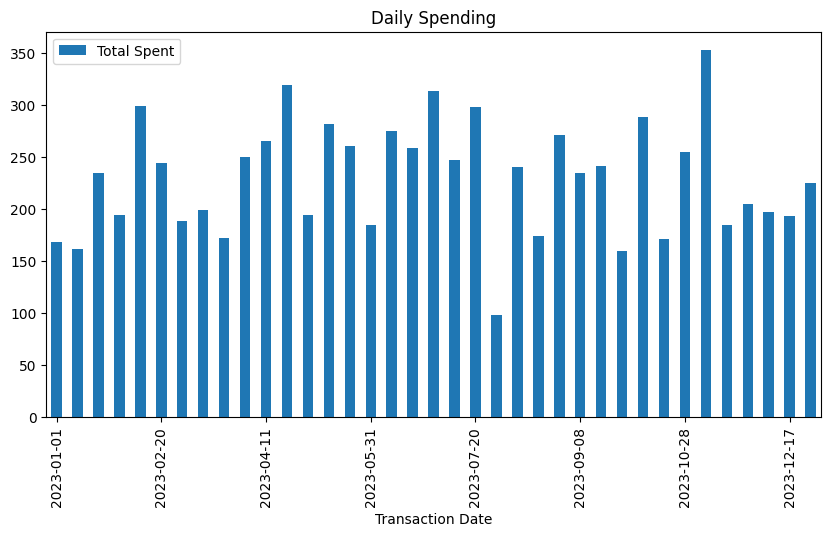

In [33]:
# Plot daily spending to see a trending increase or decrease of performance
daily_spending = df.groupby('Transaction Date')['Total Spent'].sum().reset_index().sort_values(by='Transaction Date',ascending=True)

daily_spending = daily_spending.iloc[::10]

# Create plot
fig, ax = plt.subplots(figsize=(10,5))
daily_spending.plot(kind='bar', x='Transaction Date', y='Total Spent', ax=ax, title='Daily Spending')

ax.set_xticks(ax.get_xticks()[::5])

plt.show()


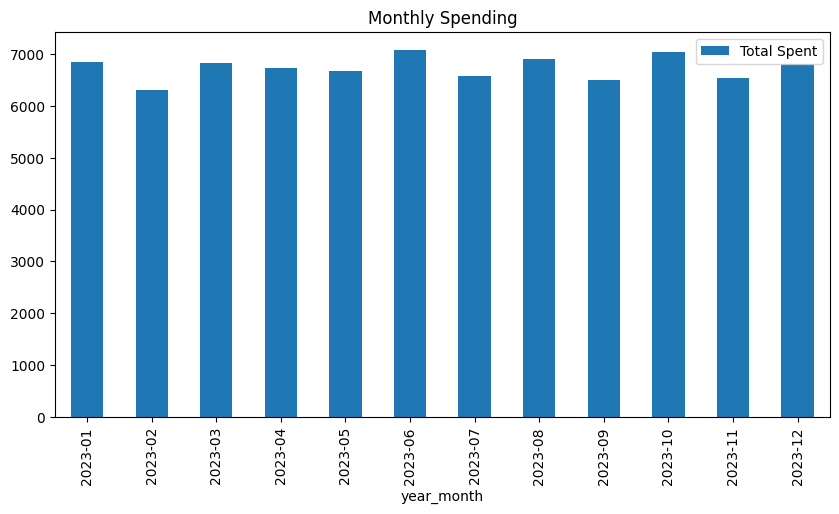

In [34]:
# Plot monthly spending to see a trending increase or decrease of performance
monthly_spending = df.groupby('year_month')['Total Spent'].sum().reset_index().sort_values(by='year_month',ascending=True)


# Create plot
fig, ax = plt.subplots(figsize=(10,5))
monthly_spending.plot(kind='bar', x='year_month', y='Total Spent', ax=ax, title='Monthly Spending')


plt.show()

In [35]:
total_other_months = 0
for row in monthly_spending.index:
  if monthly_spending.loc[row, 'year_month'] not in top_3_profitable_months['year_month']:
    total_other_months += monthly_spending.loc[row, 'Total Spent']
top_3_profitable_months.loc[len(top_3_profitable_months)] = ['other',total_other_months]

<Axes: title={'center': 'Top 3 Profitable Months'}, ylabel='Total Spent'>

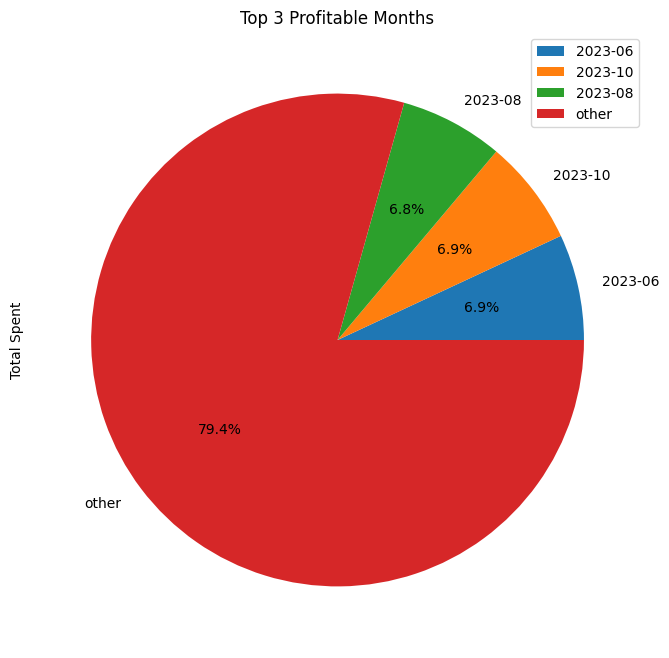

In [36]:
top_3_profitable_months.plot(kind='pie', y='Total Spent', labels=top_3_profitable_months['year_month'], autopct='%1.1f%%', title='Top 3 Profitable Months',figsize=(8,8))

<Axes: title={'center': 'Most Sold Items'}, ylabel='Quantity'>

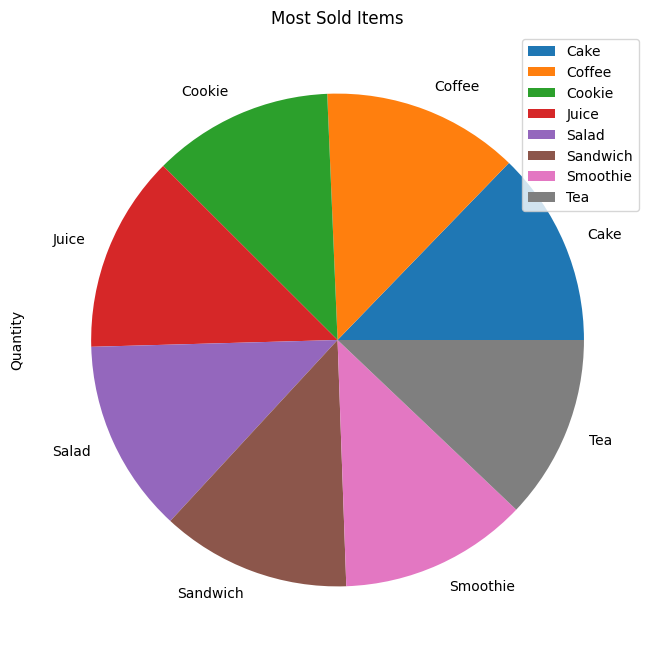

In [37]:
# Most Sold Items
items = df.dropna(subset=['Item']).groupby('Item')['Quantity'].sum().reset_index()
items.plot(x='Item', y='Quantity', kind='pie', title='Most Sold Items', figsize=(8,8),labels=items['Item'])


<Axes: title={'center': 'Payment Methods'}>

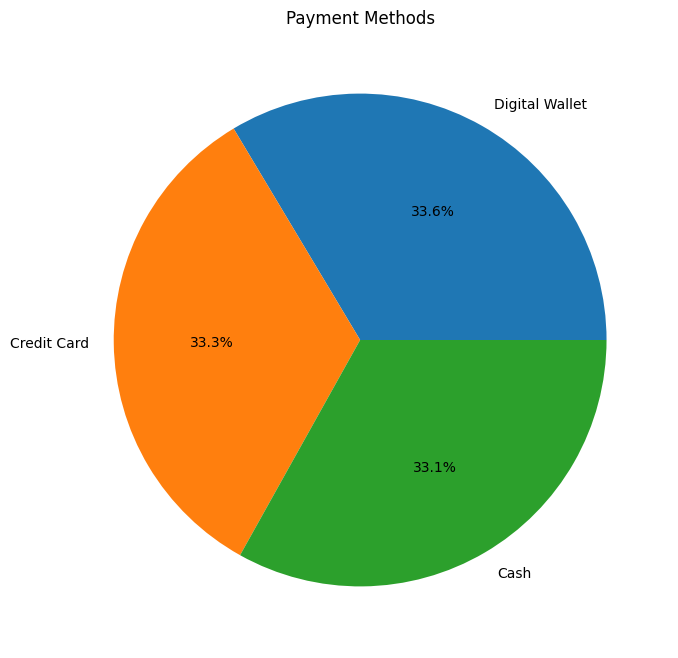

In [49]:
# Payment methods
payment_methods = df['Payment Method'].dropna().value_counts(normalize=True)
payment_methods.plot(kind='pie', title='Payment Methods', labels=payment_methods.index, autopct='%1.1f%%', figsize=(8,8),ylabel='')

<Axes: title={'center': 'Locations'}>

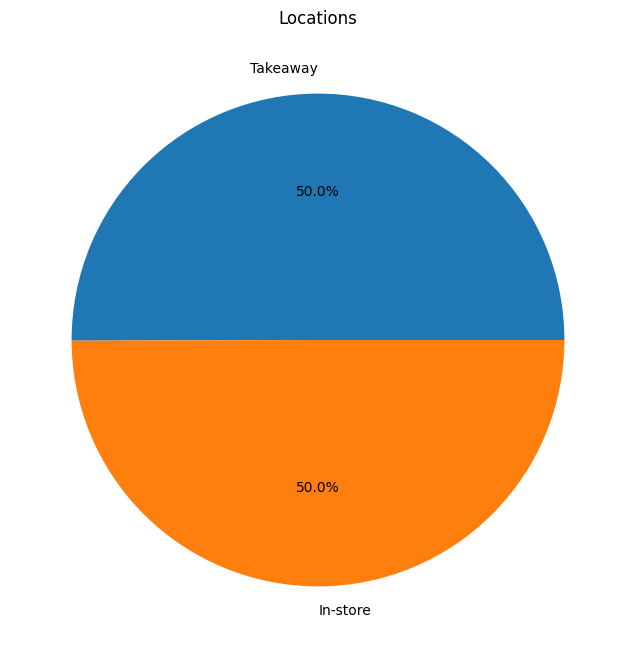

In [50]:
# Location
locations = df['Location'].dropna().value_counts(normalize=True)
locations.plot(kind='pie', title='Locations', labels=locations.index, autopct='%1.1f%%', figsize=(8,8),ylabel='')